<a href="https://colab.research.google.com/github/kscaman/DL_ENS/blob/main/TP/robustness_regularity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robustness and regularity
In this practical, we will investigate the effect of initialization on simple neural networks (MLPs).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

First, we need to automatically create large and deep MLPs. Create a function `MLP(dim_input, dim_output, dim_hidden, num_layers)` that returns an MLP with ReLU activations, `num_layers` layers and width `dim_hidden` using `nn.Sequential`.

In [2]:
def MLP(dim_input, dim_output, dim_hidden, num_layers):
    """
    num_layers: number of hidden layers
    """
    if num_layers == 0:
        return nn.Linear(dim_input, dim_output)
    layers = []
    layers.append(nn.Linear(dim_input, dim_hidden))
    layers.append(nn.ReLU())
    for i in range(num_layers - 1):
        layers.append(nn.Linear(dim_hidden, dim_hidden))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(dim_hidden, dim_output))
    return nn.Sequential(*layers)

Check that the MLP has the correct architecture for 1, 2 and 4 layers.

In [3]:
print(MLP(3,5,10,1))
print(MLP(3,5,10,2))
print(MLP(3,5,10,4))

Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
)
Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=5, bias=True)
)
Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=10, bias=True)
  (7): ReLU()
  (8): Linear(in_features=10, out_features=5, bias=True)
)


## Stability during training
We are now going to experiment with initialization. First, let's plot the function created by an MLP at initialization. The MLP will have 4 layers of width 100. Use `torch.linspace` to plot the output of the MLP on the interval $[-1,1]$.

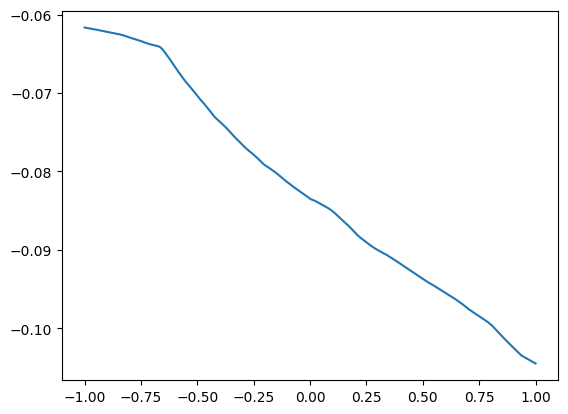

In [4]:
model = MLP(1, 1, 100, 4).to(device)

x = torch.linspace(-1, 1, 1000).to(device)
x.unsqueeze_(1)
y = model(x)

plt.plot(x.cpu().numpy(), y.cpu().detach().numpy())
plt.show()

Plot 10 functions on the same figure to have an idea of the variability of the initialization.

In [5]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', a=0)

In [21]:
def MLP_bn(dim_input, dim_output, dim_hidden, num_layers):
    """
    num_layers: number of hidden layers
    """
    if num_layers == 0:
        return nn.Linear(dim_input, dim_output)
    layers = []
    layers.append(nn.Linear(dim_input, dim_hidden))
    layers.append(nn.BatchNorm1d(dim_hidden))
    layers.append(nn.ReLU())
    for i in range(num_layers - 1):
        layers.append(nn.Linear(dim_hidden, dim_hidden))
        layers.append(nn.BatchNorm1d(dim_hidden))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(dim_hidden, dim_output))
    return nn.Sequential(*layers)

In [22]:
def plot_10_mlps(nb_hidden, reinit=False, bn=False):
    fct = MLP_bn if bn else MLP
    mlps = [fct(1, 1, 100, nb_hidden).to(device) for _ in range(10)]
    if reinit:
        for mlp in mlps:
            mlp.apply(init_weights)

    x = torch.linspace(-1, 1, 1000).to(device)
    x.unsqueeze_(1)

    y = torch.stack([mlp(x) for mlp in mlps], dim=1)

    # plot all 10 y's in different colors
    for i in range(10):
        plt.plot(x.cpu().numpy(), y[:, i].cpu().detach().numpy())
    plt.show()

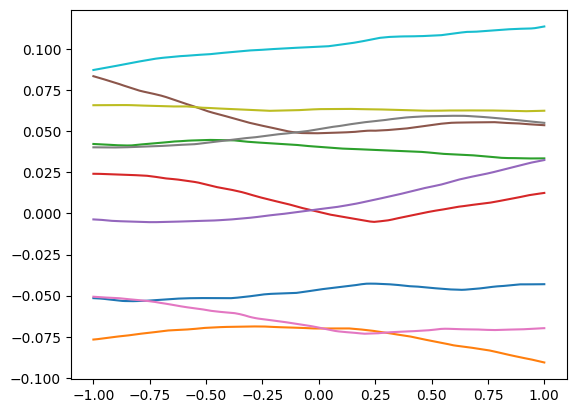

In [7]:
plot_10_mlps(4)

Increase the number of layers to 10. What happens? Is that a problem for learning?

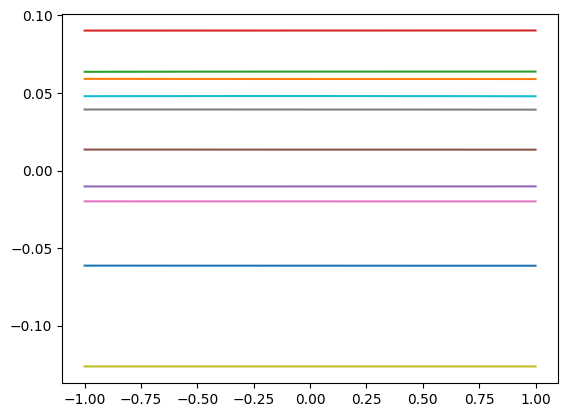

In [8]:
plot_10_mlps(10)

La fonction devient constante. C'est un problème pour l'apprentissage parce que la dérivée de l'erreur par rapport à la sortie est peut être non nulle, mais la dérivée de la sortie elle sera nulle donc la chainrule va tout tuer.

We are now going to fix this issue by applying a different initialization.
Create a function that initializes all weights of the MLP by using functions in [`nn.init`](https://pytorch.org/docs/stable/nn.init.html). To do so, first create a function `init_weights(m)` that takes a layer, check that it is linear using `isinstance(m, nn.Linear)`, and, if so, re-initializes its weights. Then, use `model.apply` to apply the function `init_weights` to all the linear layers of the model.

Again, plot 10 MLP outputs on the same figure. Is this initialization better?

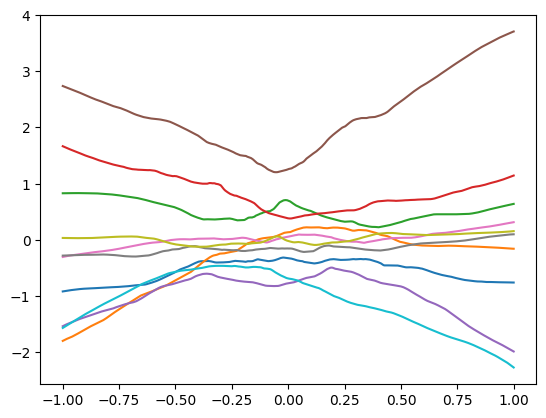

In [9]:
plot_10_mlps(10, reinit=True)

Let's now look at the distribution of values for a single input (e.g. x=1).
Plot a histogram of outputs for random initializations of the weights.

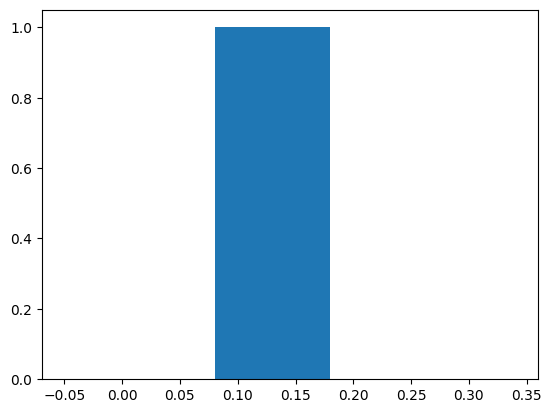

In [19]:
histo = torch.zeros(30)
mlp = MLP(1, 1, 100, 4).to(device)
x = torch.tensor([1.]).to(device)
for i in range(1000):
    y = mlp(x)
    ind = int(math.floor(y.item() * 10) + 15)
    histo[ind] += 1
histo /= 1000

plt.bar(np.arange(30) / 100, histo.cpu().numpy(), width=0.1)
plt.show()

## Fixing the initialization with batch normalization.
Create a new function `MLP_bn(dim_input, dim_output, dim_hidden, num_layers)` that creates an MLP in which a batch norm `nn.BatchNorm1d` layer is added after each hidden layer.

How is the result different at initialization? Plot several functions generated by a 10-layer MLP at initialization (with default initialization).

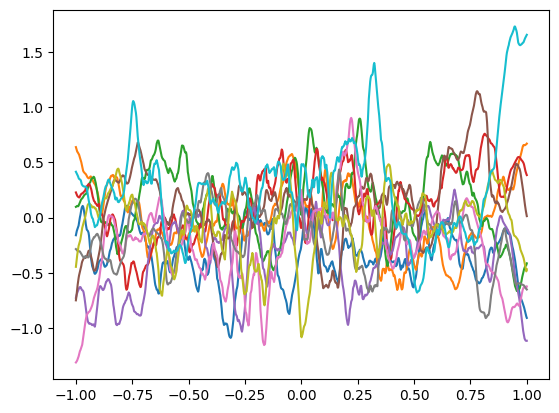

In [23]:
plot_10_mlps(10, bn=True)


⚠ **Careful though:** Batch norm depends on the **whole batch**, and uses the **training mean and standard deviation** during **evaluation**.

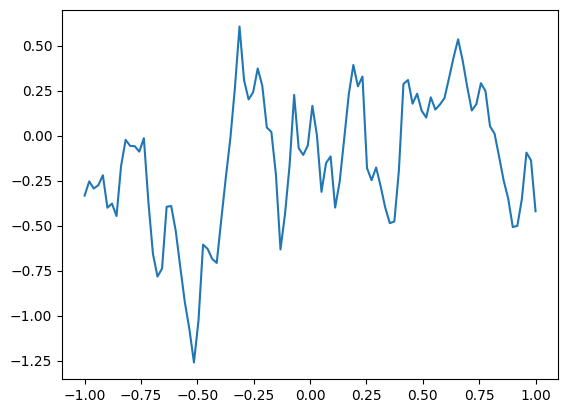

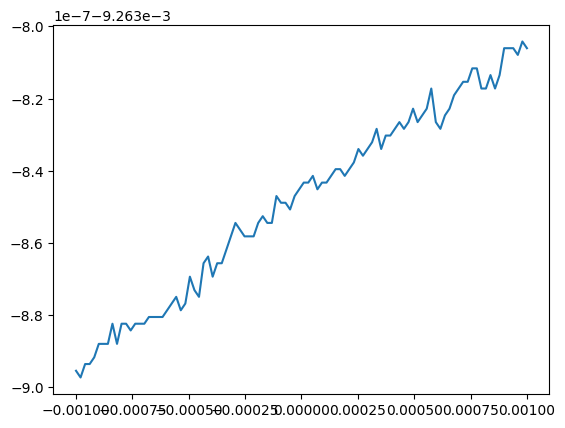

In [24]:
# WITH TRAINING DATASET ON [-1,1]
model = MLP_bn(1, 1 , 100, 10)
model.train()
x = torch.linspace(-1, 1, 100).view(-1, 1)
y = model(x)

plt.plot(x.detach().numpy(), y.detach().numpy())
plt.show()

model.eval()
x = torch.linspace(-1e-3, 1e-3, 100).view(-1, 1)
y = model(x)

plt.plot(x.detach().numpy(), y.detach().numpy())
plt.show()

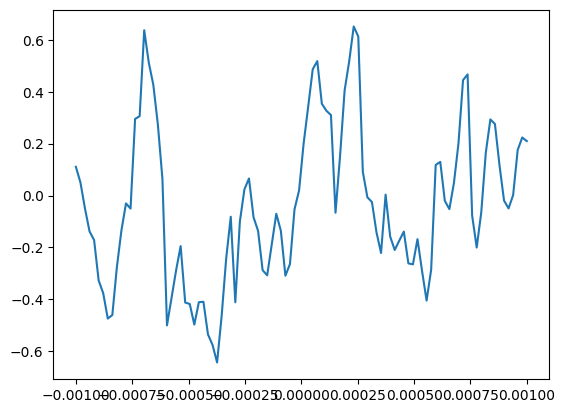

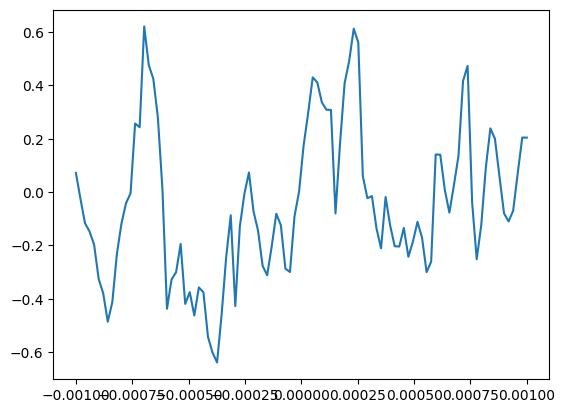

In [25]:
# WITH TRAINING DATASET ON [-1e-3,1e-3]
model = MLP_bn(1, 1 , 100, 10)
model.train()
x = torch.linspace(-1e-3, 1e-3, 100).view(-1, 1)
for _ in range(1000):
    y = model(x)

plt.plot(x.detach().numpy(), y.detach().numpy())
plt.show()

model.eval()
x = torch.linspace(-1e-3, 1e-3, 100).view(-1, 1)
y = model(x)

plt.plot(x.detach().numpy(), y.detach().numpy())
plt.show()

## Generalization and overfitting
We now investigate the generaliation capabilities of MLPs on a simple regression task $f(x)=\sin(3x) + \varepsilon$ where $\varepsilon$ is a Gaussian noise of standard deviation $0.3$.

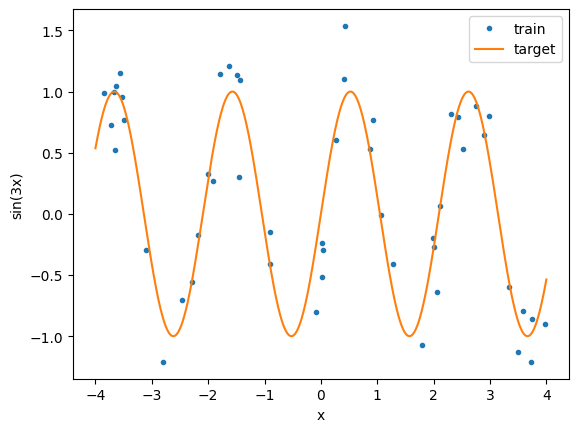

In [30]:
batch_size = 50
num_points = 50
x_train = 4 * (2 * torch.rand(num_points, 1) - 1)
y_train = torch.sin(3 * x_train) + 0.3 * torch.randn_like(x_train)
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

x_test = 4 * (2 * torch.rand(num_points, 1) - 1)
y_test = torch.sin(3 * x_test) + 0.3 * torch.randn_like(x_test)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

x = torch.linspace(-4, 4, 1000)
plt.plot(x_train, y_train, '.', label="train")
plt.plot(x, torch.sin(3 * x), label="target")
plt.legend()
plt.xlabel('x')
plt.ylabel('sin(3x)')
plt.show()

Create a training pipeline for MLPs of width `d`.

In [35]:
def create_model(d, wd=0.0):
    model = MLP_bn(1, 1, d, 8).to(device)
    loss_function = nn.MSELoss(reduction='sum')
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.6)
    return model, loss_function, optimizer, scheduler

def train(model, loss_function, optimizer):
    model.train()
    losses = []
    for input, target in train_dataloader:
        input = input.to(device)
        target = target.to(device)
        output = model(input)

        optimizer.zero_grad()
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    return np.sum(losses) / len(train_dataloader)

def test(model, loss_function):
    model.eval()
    losses = []
    with torch.no_grad():
        for input, target in test_dataloader:
            input = input.to(device)
            target = target.to(device)
            output = model(input)

            loss = loss_function(output, target)

            losses.append(loss.item())
    return np.sum(losses) / len(test_dataloader)

def training_loop(d, num_epochs, wd=0.0):
    train_losses = []
    test_losses = []

    model, loss_function, optimizer, scheduler = create_model(d, wd)
    for epoch in tqdm(range(num_epochs)):
        train_loss = train(model, loss_function, optimizer)
        test_loss = test(model, loss_function)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        scheduler.step()

    plt.loglog(train_losses, label="train")
    plt.loglog(test_losses, label="test")
    plt.legend()
    plt.xlabel("Number of epochs")
    plt.ylabel("train and test losses")
    plt.show()
    return train_losses[-1], test_losses[-1], model

For increasing model sizes, the training error decreases. However, the test error first decreases then increases due to the model overfitting the data. If the number of parameters increases drastically, this tends to regularize/smoothen the model, and thus improve generalization. This is called **implicit regularization**.

100%|██████████| 2000/2000 [00:09<00:00, 212.00it/s]


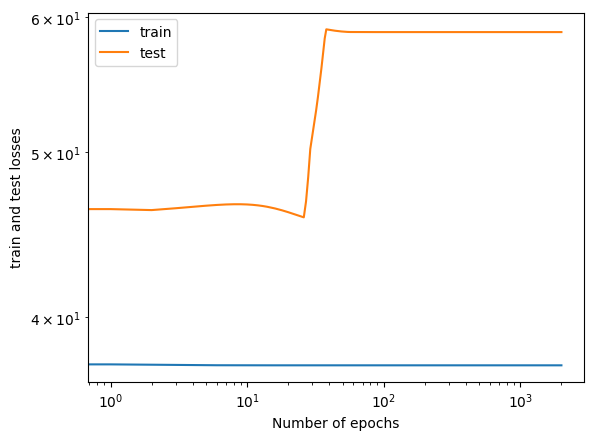

100%|██████████| 2000/2000 [00:09<00:00, 203.03it/s]


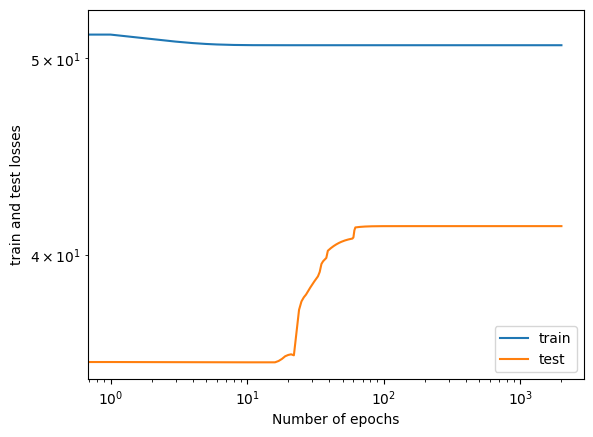

100%|██████████| 2000/2000 [00:09<00:00, 208.52it/s]


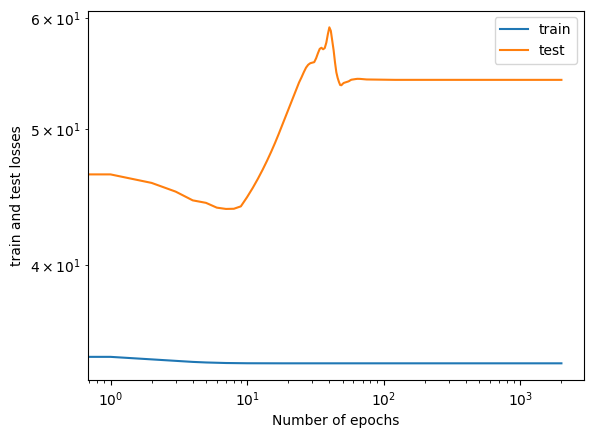

100%|██████████| 2000/2000 [00:10<00:00, 199.20it/s]


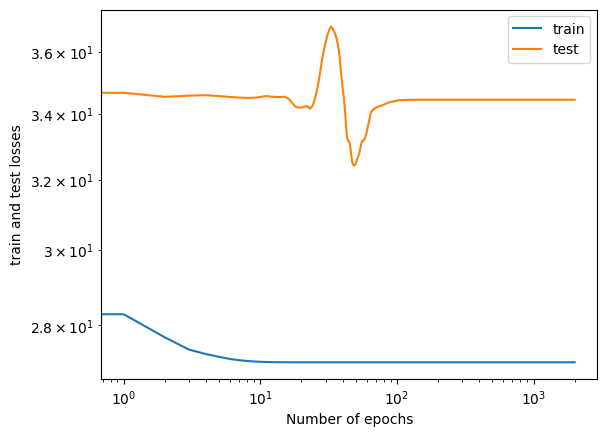

100%|██████████| 2000/2000 [00:11<00:00, 179.39it/s]


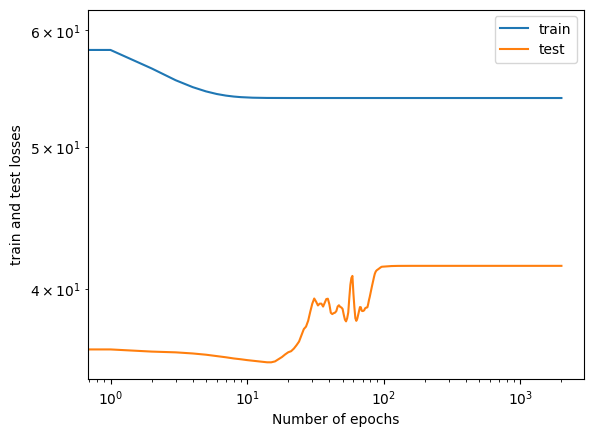

100%|██████████| 2000/2000 [00:15<00:00, 129.68it/s]


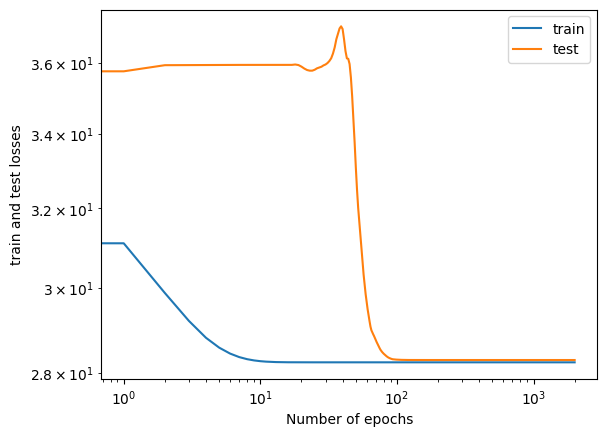

100%|██████████| 2000/2000 [00:14<00:00, 133.39it/s]


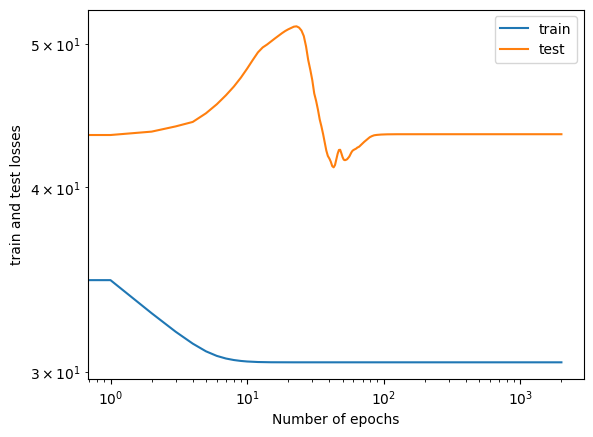

100%|██████████| 2000/2000 [00:15<00:00, 128.83it/s]


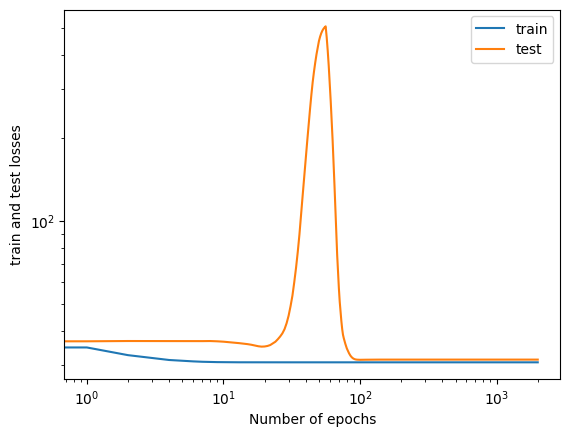

100%|██████████| 2000/2000 [00:15<00:00, 128.13it/s]


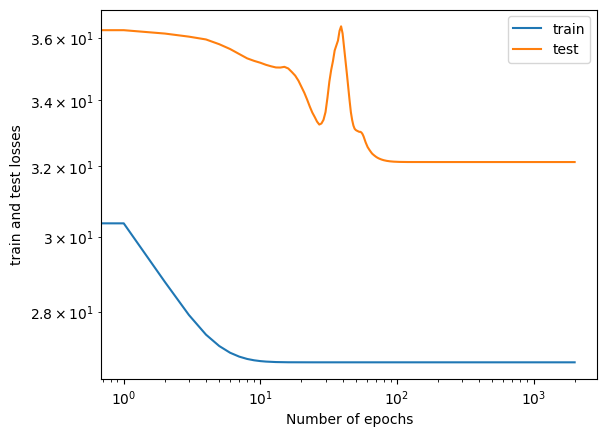

100%|██████████| 2000/2000 [00:14<00:00, 134.09it/s]


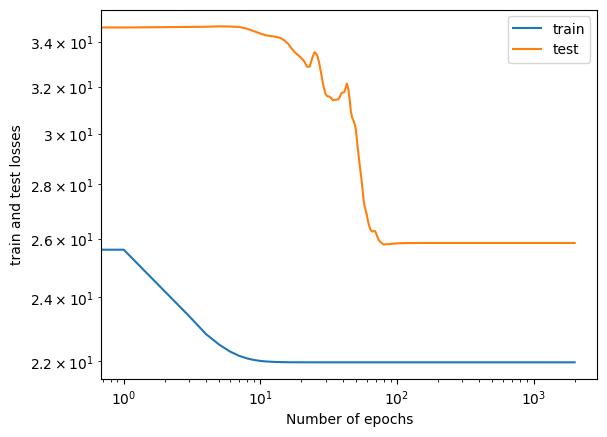

100%|██████████| 2000/2000 [00:15<00:00, 132.20it/s]


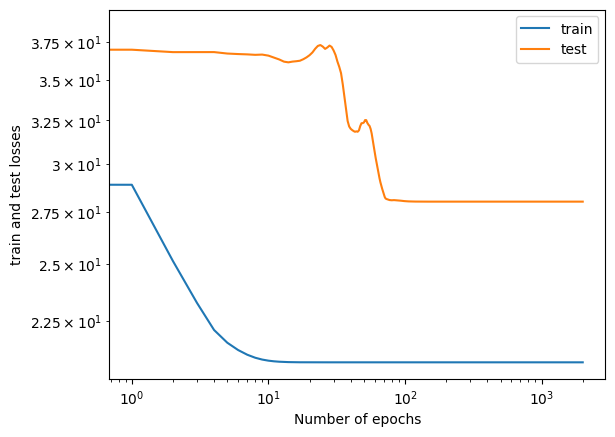

100%|██████████| 2000/2000 [00:15<00:00, 129.69it/s]


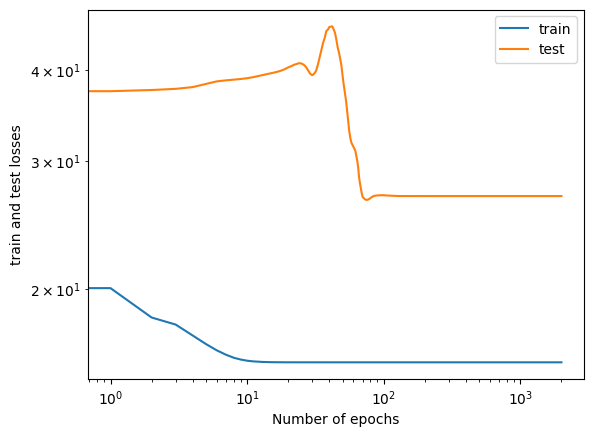

100%|██████████| 2000/2000 [00:14<00:00, 142.46it/s]


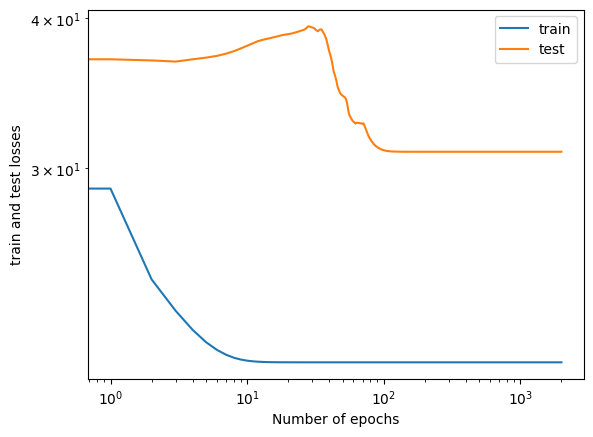

100%|██████████| 2000/2000 [00:13<00:00, 147.54it/s]


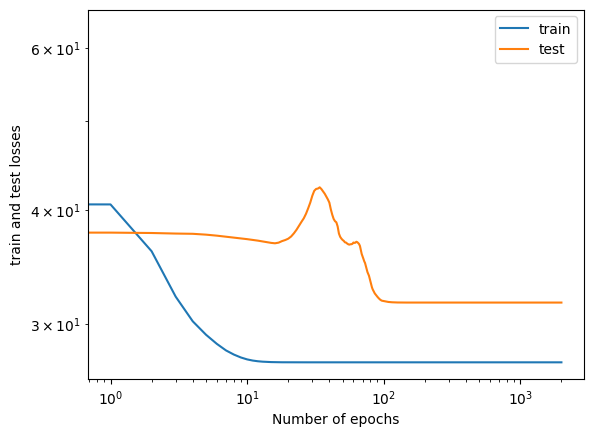

100%|██████████| 2000/2000 [00:15<00:00, 126.53it/s]


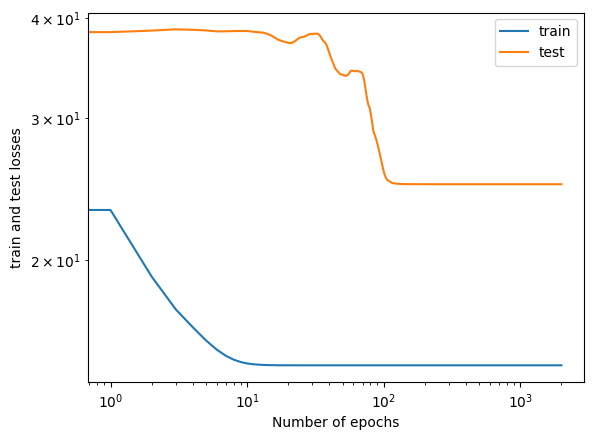

100%|██████████| 2000/2000 [00:14<00:00, 134.94it/s]


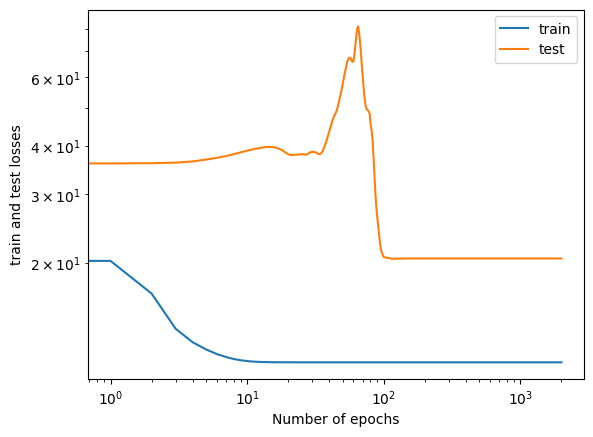

100%|██████████| 2000/2000 [00:15<00:00, 132.08it/s]


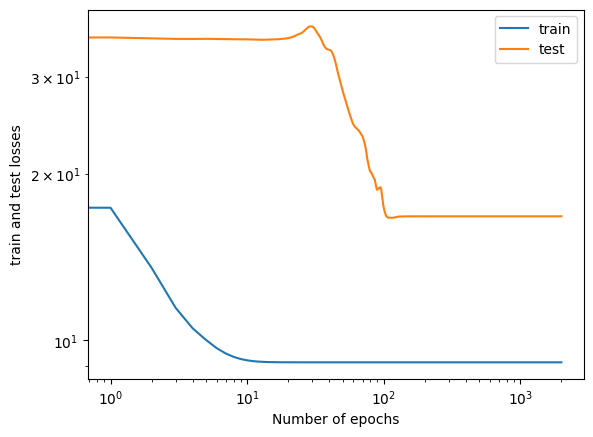

100%|██████████| 2000/2000 [00:15<00:00, 132.01it/s]


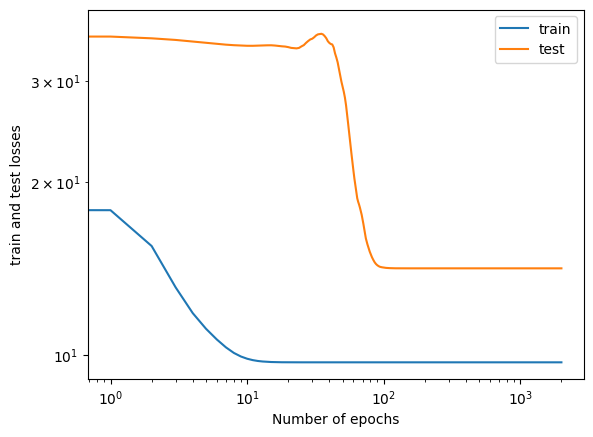

100%|██████████| 2000/2000 [00:14<00:00, 141.49it/s]


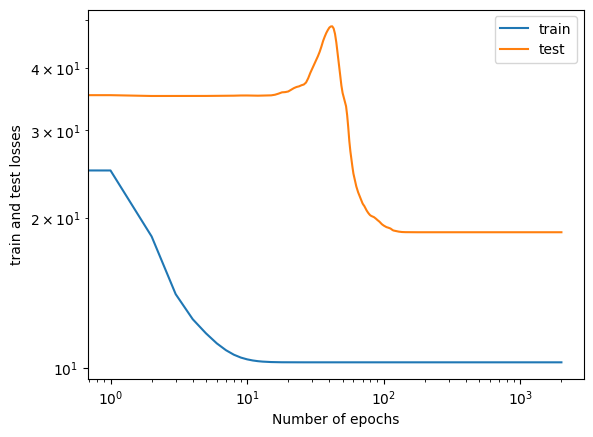

100%|██████████| 2000/2000 [00:14<00:00, 137.60it/s]


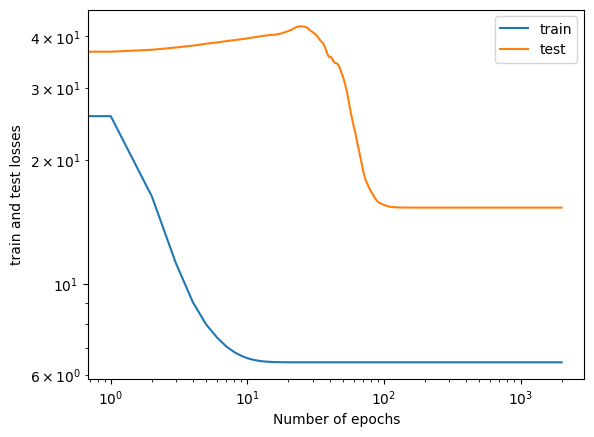

100%|██████████| 2000/2000 [00:15<00:00, 133.16it/s]


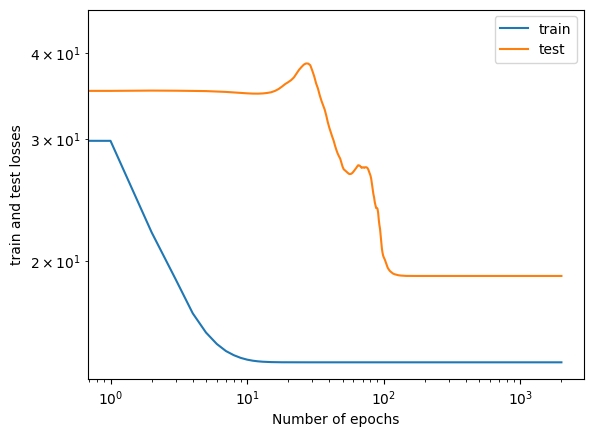

100%|██████████| 2000/2000 [00:15<00:00, 128.11it/s]


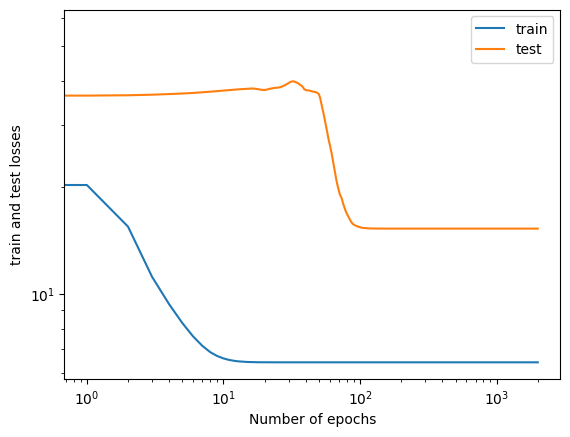

100%|██████████| 2000/2000 [00:16<00:00, 121.72it/s]


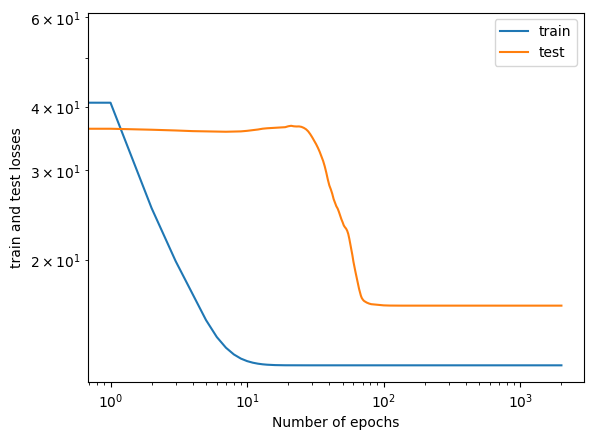

100%|██████████| 2000/2000 [00:17<00:00, 116.54it/s]


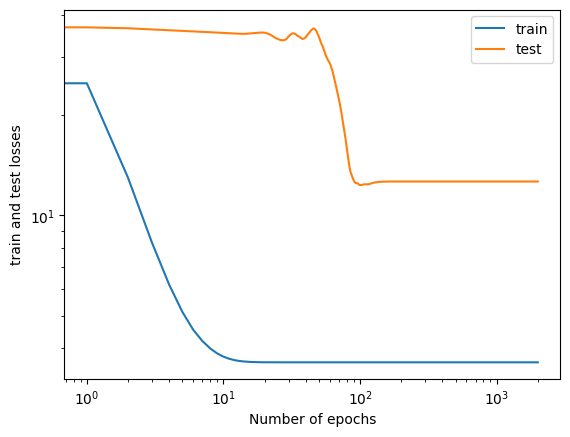

100%|██████████| 24/24 [05:47<00:00, 14.46s/it]


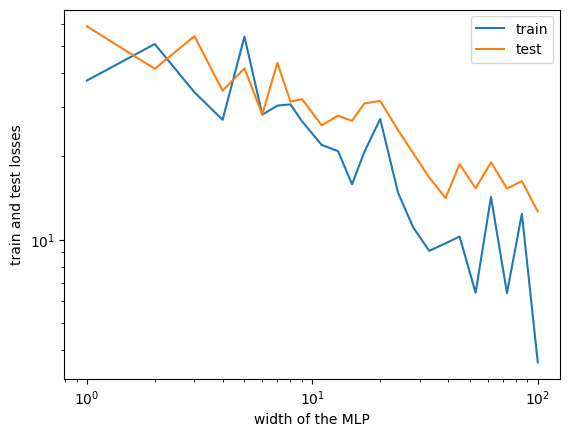

In [32]:
dim_hidden = [int(d) for d in np.unique(np.round(10 ** np.linspace(0, 2, 30)))]
train_losses, test_losses = [], []
for d in tqdm(dim_hidden):
    train_loss, test_loss, model = training_loop(d, 2000)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

plt.loglog(dim_hidden, train_losses, label="train")
plt.loglog(dim_hidden, test_losses, label="test")
plt.legend()
plt.xlabel("width of the MLP")
plt.ylabel("train and test losses")
plt.show()

Train a large model ($d=10^2$) and plot the target function and the output of the model. Is it smoother?

100%|██████████| 2000/2000 [00:13<00:00, 153.82it/s]


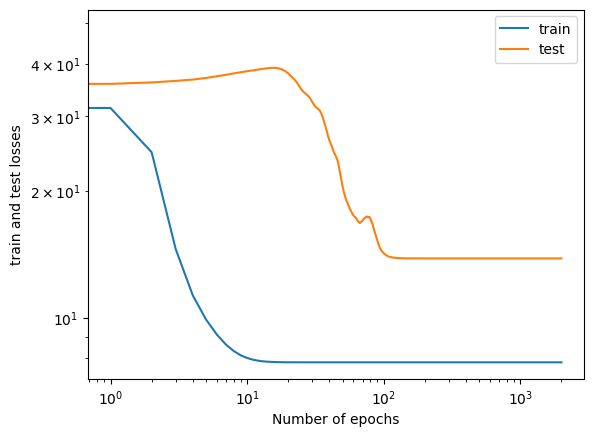

In [34]:
_ = training_loop(100, 2000)

Add a weight decay (`weight_decay=3`) to the optimizer. Is the output of the model smoother?

100%|██████████| 2000/2000 [00:13<00:00, 152.22it/s]


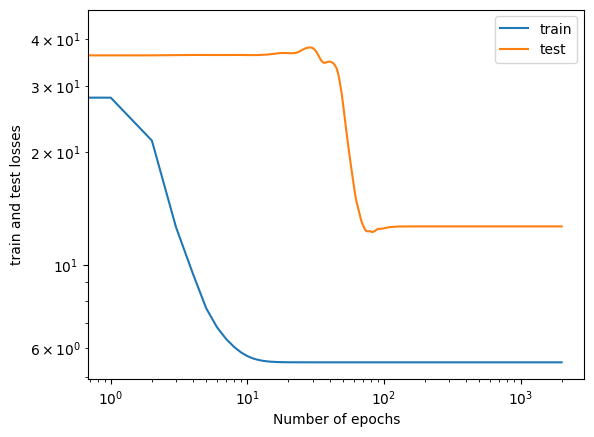

In [36]:
_ = training_loop(100, 2000, wd=3)